In [1]:
# !pip install -U datasets diffusers einops

# Simple Conditional Diffusion

This is a notebook to inspect some interesting aspects of [Conditional Diffusion Model](https://openreview.net/pdf?id=qw8AKxfYbI) training (here, conditioned on a class label) from a simplified point of view. There are multiple superb blogs and papers discussing the underlying mathematics and derivations of diffusion models. However, sparingly few explain in layman terms how the hyper parameters they chose relate to this theory. 

This notebook builds off the `01_simple_ddpm` notebook, so please refer to that for more details. We will only discuss the additional details required for conditional diffusion in this notebook. Most of the literature for this notebook is from the paper [Classifier-Free Diffusion Guidance](https://openreview.net/pdf?id=qw8AKxfYbI).

**Note: This is NOT a notebook to understand the underlying mathematics of Diffusion Models.** As mentioned above, there are plenty of much more appropriate resources in various posts and papers.

Topics covered :

- Conditioning a Diffusion Model on a class label
- Creation of custom Sampling Pipeline for Conditional Sequence generation task
- How to overfit a small batch of training samples with Diffusion Training
- Improving the efficiency of small dataset fitting
- Sampling 
- Classifier Free Guidance Sampling


In [2]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from dataclasses import dataclass
from typing import Union, Optional

import torch
from torch import nn, einsum
import torch.nn.functional as F

c:\Users\somsh\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Architecture - GPT

We re-use the GPT architecture from the first notebook, with a very minor modification - including an optional class label as an input tensor.

- ``GPT - Class Embedding``: We create a simple Embedding layer with C+1 tokens, 1 for each class, and where index `0` will correspond to "No class conditioning". This latter point is important - turns out, you can jointly train a single model to do both conditional and unconditional generation simply by **not** providing class labels during training with some chance (usually 10% chance).

- ``Classifier Free Guidance at Inference``: Once this is done, we can not only generate both conditional and unconditional samples, we can also perform ``Classifier Free Guidance`` - providing a model with a score that demonstrates the strength of conditioning of the class label on the generated image. It will be demonstrated in the latter half of the notebook.

- ``Param Count``: For a few samples from the batch, we can get away with very few trainable parameters (discounting the parameters of the large embedding matrices since we do not train on all timesteps).

Reference: https://github.com/karpathy/nanoGPT 

In [3]:
def new_gelu(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):

    def __init__(self, n_embd: int, n_head: int, dropout: float = 0.0):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        
        self.n_head = n_head
        self.n_embd = n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, n_embd: int, dropout: float = 0.0):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd)
        self.c_proj  = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = new_gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, n_embd: int, n_head: int, dropout: float = 0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = SelfAttention(n_embd, n_head, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x, t):
        # Try uncommenting below block to see if adding the diffusion timestep
        # embedding to every block benefits the quality of samples or not.
        # x = x + t
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# Added block
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, max_timesteps: int = 10000):
        super().__init__()
        self.dim = dim
        self.max_timesteps = float(max_timesteps)

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.max_timesteps) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class PositionalEmbedding(nn.Module):

    def __init__(self, dim, max_timesteps: int):
        super().__init__()
        self.pe = SinusoidalPosEmb(dim=dim, max_timesteps=max_timesteps)

    def forward(self, x):
        out = self.pe(x)
        return out
        

@dataclass
class GPTConfig:
    dim: int
    num_classes: int
    block_size: int = 10000
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 128
    dropout: float = 0.1

class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            input_proj = nn.Linear(config.dim, config.n_embd, bias=False),
            wte = nn.Embedding(config.block_size, config.n_embd),
            wpe = PositionalEmbedding(config.n_embd, max_timesteps=config.block_size),
            class_emb = nn.Embedding(config.num_classes + 1, config.n_embd, padding_idx=0),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(n_embd=config.n_embd, n_head=config.n_head, dropout=config.dropout) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
            output_proj = nn.Linear(config.n_embd, config.dim, bias=False),
        ))

        # report number of parameters
        n_params = sum(p.numel() for p in self.parameters())
        embd_params = sum(p.numel() for p in self.transformer.wte.parameters())
        embd_params += sum(p.numel() for p in self.transformer.class_emb.parameters())
        print("Total number of parameters: %.2fM" % (n_params/1e6,))
        print("Non-Embedding number of parameters: %.2fM" % ((n_params - embd_params)/1e6,))
        print("Embedding number of parameters: %.2fM" % (embd_params/1e6,))

    def forward(self, x, time, cls=None):
        device = x.device
        b, d, t = x.size()  # [B, C, T]

        assert d == self.config.dim, f"Expected input dim {self.config.dim} got {d}"

        # Setup time embedding
        time = time.to(dtype=torch.long, device=device) # torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
        if time.ndim == 0:
          time = time.unsqueeze(0).repeat(b)

        assert x.size(0) == time.size(0), f"Time ({len(time)}) and input batch size ({len(x)}) must match"

        # Setup class embedding
        if cls is not None:
            cls = cls.to(dtype=torch.long, device=device)

            # Check for time dim matches batch dim
            if cls.ndim == 0:
                cls = cls.unsqueeze(0).repeat(b)

            assert x.size(0) == cls.size(0), f"Class ({len(cls)}) and input batch size ({len(x)}) must match"

            # Compute the class embedding
            cls_emb = self.transformer.class_emb(cls)  # [B, D]
        else:
            # Use a zero vector if no class is provided to perform classifier free guidance sampling later
            cls_emb = torch.zeros(b, self.config.n_embd, device=device)  # [B, D]

        # forward the GPT model itself
        x_input = x
        
        x = x.transpose(1, 2)  # [B, T, C]
        inp_emb = self.transformer.input_proj(x)  # [B, T, D]
        seq_emb = self.transformer.wte(torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)) # [1, t, D]
        time_emb = self.transformer.wpe(time).unsqueeze(1) # time embeddings of shape (time, 1, D); len(time) = B
        cls_emb = cls_emb.unsqueeze(1)  # [B, 1, D]

        # You can try to remove `seq_emb` from the following line to see the model fail to converge and generate any samples at all.
        # We add cls_emb to the input to the transformer to perform classifier free guidance sampling later plus 
        # it conditions the model on the class label.
        x = self.transformer.drop(inp_emb + seq_emb + cls_emb)

        for block in self.transformer.h:
            # To see the necessity of the diffusion time emb, you can multiply it
            # with 0 to get a model that has no conditioning on the diffusion timestep.
            x = block(x, time_emb)
        x = self.transformer.ln_f(x)
        x_out = self.transformer.output_proj(x)
        x_out = x_out.transpose(1, 2)
        
        x = x_input + x_out

        return x

    # Add two properties used by HF Sampling Pipeline
    @property
    def dtype(self):
      return next(self.parameters()).dtype

    @property
    def device(self):
      return next(self.parameters()).device

# Preparing a Dataset

In this example, we will be using a tiny speech recognition dataset for Japanese vowels rather than the usual image diffusion. We chose such a task specifically because image diffusion has been studied extensively, and usually training even a single image diffusion model on CPU would take a non trivial amount of compute or memory.

We will use the [Japanese Vowels dataset](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels), where each sample is a multivariate time series comprising of 12 LPC cepstrum coefficients over a of 26 frames. The amount of compute required to train on this data is trivial compared to even a single 256x256 image.

Most importantly, though the dataset has 12 coefficients, we can easily visualize a single channel as a basic line plot, and we will later see that this sequence has a distinctive signature which we will task the diffusion model of learning.

## Conditioning a Diffusion Model

Note that since this dataset originally represents Japanese Vowels, we are provided speaker labels ranging from Speaker `1` to Speaker `9`.
We will use this as a conditioning variable for the diffusion model.

**Note**: There are many possible ways to condition the diffusion model - the only major requirement seems to be that it must be somehow passed to the model during training. This can include embedding lookups (as used here), other images, audio features or raw audio waveforms, latents (for latent diffusion) or even one hot vectors.

You can combine these conditioning tokens either via simple summation (used here), concatenation, cross attention, [Featurewise Linear Modulation](https://arxiv.org/abs/1709.07871) or many other approaches. Each has some tradeoffs and can provide better conditioning at the cost of memory or execution speed.

## Downlaod processed dataset

This dataset is already processed as part of prior research for multivariate time series classification tasks at my repository, so we will simply download and use the processed numpy arrays. 

In [4]:
import os

if not os.path.exists("/content/JapaneseVowels-20180329T000739Z-001.zip"):
  !wget https://github.com/titu1994/MLSTM-FCN/releases/download/v1.0/JapaneseVowels-20180329T000739Z-001.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
import zipfile
import os

dataset_root = "dataset/"
os.makedirs(dataset_root, exist_ok=True)

with zipfile.ZipFile('JapaneseVowels-20180329T000739Z-001.zip', 'r') as zip_ref:
  zip_ref.extractall(dataset_root)

## Process the dataset

We will normalize the speech features to the range `[-1, 1]` as in the DDPM tutorial.

For labels, we will simply keep track of a mapping of each individual `Speaker ID` to all the audio samples of that speaker in order to more easily construct a training dataset later on.

In [6]:
import numpy as np

jp_root = os.path.join(dataset_root, "JapaneseVowels")

x_train = np.load(os.path.join(jp_root, "X_train.npy"))  # [B, C, T]
x_test = np.load(os.path.join(jp_root, "X_test.npy"))  # [B, C, T]
y_train = np.load(os.path.join(jp_root, "y_train.npy")).reshape(-1)  # [B]
y_test = np.load(os.path.join(jp_root, "y_test.npy")).reshape(-1)  # [B]

# Normalize dataset to [-1, 1] range
x_train = (x_train - x_train.min(-1, keepdims=True)) / (x_train.max(-1, keepdims=True) - x_train.min(-1, keepdims=True))
x_train = 2 * x_train - 1

x_test = (x_test - x_test.min(-1, keepdims=True)) / (x_test.max(-1, keepdims=True) - x_test.min(-1, keepdims=True))
x_test = 2 * x_test - 1

# Convert dataset to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

channels = x_train.shape[1]
timesteps = x_train.shape[2]
classes = np.unique(y_train).shape[0]
class_labels = np.unique(y_train)

# build a dictionary with class labels mapping to list of x_train indices
class_to_idx = {label: np.where(y_train == label)[0] for label in class_labels}

print("Loaded X Train :", x_train.shape, "Max", x_train.max(), "Min", x_train.min())
print("Loaded X Test  :", x_test.shape, "Max", x_test.max(), "Min", x_test.min())
print("Labels :", class_labels)

Loaded X Train : torch.Size([270, 12, 26]) Max tensor(1.) Min tensor(-1.)
Loaded X Test  : torch.Size([370, 12, 26]) Max tensor(1.) Min tensor(-1.)
Labels : [1 2 3 4 5 6 7 8 9]


# Check model forward pass

Given a dataset and a model, lets make sure that the forward pass works as expected.

Note: For a small dataset, we wont be using millions of parameters, a few hundred thousand (or less) will be sufficient.

In [7]:
config = GPTConfig(dim=channels, num_classes=classes, n_embd=32, n_head=4, n_layer=4, dropout=0.0)
model = GPT(config)

Total number of parameters: 0.37M
Non-Embedding number of parameters: 0.05M
Embedding number of parameters: 0.32M


In [8]:
with torch.no_grad():
  tmp_ip = x_train[0:8]
  tmp_cls = y_train[0:8]
  out = model(tmp_ip, time=torch.tensor(list(range(8)), dtype=torch.long), cls=tmp_cls)
  print("Input  :", tmp_ip.shape)
  print("Classes:", tmp_cls.shape)
  print("Output :", out.shape)

Input  : torch.Size([8, 12, 26])
Classes: torch.Size([8])
Output : torch.Size([8, 12, 26])


# Diffusion Scheduler

We will use the simple diffusion scheduler from the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) that has been implemented in [Hugging Face](https://huggingface.co/docs/diffusers/api/schedulers/ddpm).

Similar to the DDPM tutorial, we will use a reduced number of timesteps (50) to speed up convergence on a toy dataset in a relatively short time even on CPU.


In [9]:
from diffusers import DDPMScheduler
from diffusers.schedulers.scheduling_ddpm import DDPMSchedulerOutput
from diffusers.utils import randn_tensor

# Setup Constants
DIFFUSION_TIMESTEPS = 50  # Number of Diffusion Steps during training. Note, this is much smaller than ordinary (usually ~1000)
beta_start = 0.0001  # Default from paper
beta_end = 0.2  # NOTE: This is different to accomodate the much shorter DIFFUSION_TIMESTEPS (Usually ~1000). For 1000 diffusion timesteps, use 0.02.
clip_sample = True  # Used for better sample generation

noise_scheduler = DDPMScheduler(num_train_timesteps=DIFFUSION_TIMESTEPS, beta_end=beta_end, clip_sample=clip_sample)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.12.1",
  "beta_end": 0.2,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "num_train_timesteps": 50,
  "prediction_type": "epsilon",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

# Custom Diffusion Pipeline for Conditional Time Series Generation

We will be using the [diffusers](https://huggingface.co/docs/diffusers/index) throughout the notebook in order to abstract away the diffusion process logic. The code for ``DDPM`` can be read in order to understand the paper better.

Here, we will write a custom ``DiffusionPipeline`` for time series data, which is mostly a replication of the ``DDPMPipeline`` with some additional arguments.

One of the important arguments will be `class_ids` - which can be `None` (unconditional generation) or an int id representing the Speaker ID.

In [10]:
from diffusers import DiffusionPipeline
from typing import List, Optional, Tuple, Union

@dataclass
class SequenceDataOutput:
  sequences: List[torch.Tensor]
  history: List[torch.Tensor]


class ClassConditionedSequenceDDPMPipeline(DiffusionPipeline):

  def __init__(self, model: GPT, scheduler: DDPMScheduler):
    super().__init__()
    self.register_modules(model=model, scheduler=scheduler)

  @torch.no_grad()
  def __call__(self, 
        batch_size: int = 1,
        class_ids: Union[int, Optional[torch.Tensor]] = None,  # The only significant change from the DDPM tutorial
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = DIFFUSION_TIMESTEPS,
        return_dict: bool = True,
        return_all: bool = False,  # new flag to return all the diffusion reverse process steps as a list
        explicit_noise: torch.Tensor = None,  # We can pass in an explicit loss value to ensure diffusion backward process is working as expected
        **kwargs,           
  ) -> SequenceDataOutput:
    self.scheduler: DDPMScheduler
    self.model: GPT

    # Get the sequence length from the notebook's globals as they were defined above when loading the dataset
    # Or use the user defined value if passed.
    # NOTE: Since we train on a single sample with exact seq_len and seq_dim, changing this will NOT work during inference.
    seq_len = kwargs.get('seq_len', timesteps)
    seq_dim = kwargs.get('channels', channels)

    # Sample noise as an init to the reverse process, if no noise was explicitly provided
    if explicit_noise is None:
      sequence_data = torch.randn(batch_size, seq_dim, seq_len, device=self.device, generator=generator)
    else:
      sequence_data = explicit_noise.to(device=device)

    # Set inference timesteps
    self.scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    # Check whether to mantain the history of all reverse diffusion process steps
    if return_all:
      history = [sequence_data.cpu()]
    else:
      history = None

    # Convert class_ids to tensor if not already
    if isinstance(class_ids, int):
      class_ids = torch.tensor(class_ids, device=self.device)

    for t in self.progress_bar(self.scheduler.timesteps):
        # 1. predict noise model_output (NOTE: We are passing in the cls ids to the model)
        # All other steps remain the same as the DDPM tutorial !
        model_output = self.model(sequence_data, t, cls=class_ids)

        # 2. compute previous image: x_t -> x_t-1  # prev_sample
        sequence_data = self.scheduler.step(model_output, t, sequence_data, generator=generator).prev_sample

        # Optional: Preserve history of intermediate step generation
        if history is not None:
          history.append(sequence_data.cpu().clone())
    
    # Clamp to allowed prediction range
    sequence_data = sequence_data.clamp(min=-1.0, max=1.0)
    
    if not return_dict:
        return (sequence_data,)

    return SequenceDataOutput(sequences=sequence_data, history=history)

# Dataloader with a Few samples per Speaker

To learn a diffusion model from a single sample per speaker, we dont really need to create a PyTorch Dataset or DataLoader, but for ease of use where we may want to experiment with more than one sample (or even the entire dataset), we will write a simple data loader.

Note that below we select samples from the prior mapping, such that at least one sample from every speaker id will be available during training. 

In [11]:
BATCHSIZE = 128  # used only if you select more than one sample below

In [12]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):

  def __init__(self, X_train, y_train, num_samples_per_cls: int, class_to_idx: dict):
    super().__init__()

    self.class_to_idx = class_to_idx
    self.num_samples = num_samples_per_cls
    self.X_train = X_train
    self.y_train = y_train
    
    # select unique subset of samples from the dataset given class_to_idx mapping and num_samples
    self.sample_idxs = []
    for class_id, idxs in class_to_idx.items():
      self.sample_idxs.extend(idxs[:num_samples_per_cls])

    self.data = X_train.clone()[self.sample_idxs]
    self.labels = y_train.clone()[self.sample_idxs]

  def __getitem__(self, idx):
    sample = self.data[idx]  # [C, T]
    label = self.labels[idx]  # [1]
    return sample, label

  def __len__(self):
    return len(self.data)

In [13]:
num_samples_per_class = 2

assert 0 < num_samples_per_class <= 10, "Number of samples per class cannot be > number of samples in train set or <= 0!"

dataset = TimeSeriesDataset(x_train, y_train, num_samples_per_class, class_to_idx)
dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=0, pin_memory=True)
print("Dataset size :", len(dataset[0]), "\nSingle Sample shape: ", dataset[0][0].shape, "\nLabel: ", dataset[0][1])

Dataset size : 2 
Single Sample shape:  torch.Size([12, 26]) 
Label:  tensor(1)


In [14]:
# get one x_train sample of every class from class_to_idx
sequences = []
sequences_labels = []
for class_id, idxs in class_to_idx.items():
    sequences.extend(x_train[idxs[:1]])
    sequences_labels.extend(y_train[idxs[:1]])

print("Labels in samples :", sequences_labels)

Labels in samples : [tensor(1), tensor(2), tensor(3), tensor(4), tensor(5), tensor(6), tensor(7), tensor(8), tensor(9)]


# Prepare Model for training

The model will learn on a few samples per speaker, so we do not need to have too many parameters or too much hyper parameter optimization. Standard Adam optimizer with a cosine schedule to lower the LR for 1000 steps should be enough.

In [15]:
from torch.optim import Adam
from diffusers.optimization import get_cosine_schedule_with_warmup

epochs = int(1e3)  # 1000 'epochs' seems a lot, but with 1 sample per speaker (9 speakers) in the dataset, 1 epoch = 1 update step = 18 samples
num_steps = len(dataloader) * epochs

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create small model with ~ 400,000 params (non embedding)
# NOTE: Such a small model is OK since we are training on a single sample
#       We would need to increase model size to train on the entire dataset !
config = GPTConfig(dim=channels, num_classes=classes, n_embd=128, n_head=4, n_layer=2, dropout=0.0)
model = GPT(config)
model.to(device)

# Since we will train on a single sample, we can use very high LR to converge faster with certain tricks
optimizer = Adam(model.parameters(), lr=1e-2, betas=[0.9, 0.999])

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_steps,
)

Total number of parameters: 1.68M
Non-Embedding number of parameters: 0.40M
Embedding number of parameters: 1.28M


-------

You can uncomment the following line and perhaps change the path to load a pretrained checkpoint (after training at least one model).

In [16]:
# Load previous checkpoint if necessary
# model.load_state_dict(torch.load("/content/checkpoints/jp_vowels.pt"))

# Training

Training of a Conditional DDPM model is almost exactly the same as the unconditional DDPM tutorial. The main difference is that we provide the conditioning input to the model during training, and that with some chance, we may skip the label during training to jointly train an unconditional Diffusion model.

------

* Joint training of conditional and unconditional Diffusion model 

We use a simple variable `cfg_training_prob = 0.1` that denotes the probability of training on a batch of samples without any given class label. We select it to be 10% chance as in the Conditional Diffusion. 

## Efficiently training on a small number of samples

For a single sample, the diffusion model must learn the following (vastly simplified) -

* Map a single timestep $t \: ; 0 \le t < T$
* And a single input data point of shape $\mathbb{R}^{C \times T}$, to which noise $ϵ$ is added according to the diffusion schedule $β$
* To $ϵ$ itself

In this scenario, we have three sources of randomness - 
* The sampled input datapoint
* The timestep $t$ that defines the diffusion timestep of this step
* The gaussian noise that must be predicted $ϵ$

During diffusion model training over real datasets, training is memory bound due to the size of the tensors for $x$ and $ϵ$, along with the model's forward-backward pass + gradients. Therefore there is no choice but to sample $t$.

Intuitively, it can be considered that for a single given $x_{sample}$ - you can sample *any* $t$, and independently sample *any* $\epsilon$ to perform a single gradient update. 

While $t$ is constrained to a finite set of values, $T$ can be very large (usually $1000$) and so you would need a large number of update steps to sample all possible $t$.

Furthermore, for any given $t$, you can sample nearly infinite variations of gaussian noise $\epsilon$ - so the model would need a large number of update steps if we trained it on a single $t$ and a single $ϵ$.

Fortunately, in our case $x$ is a tiny tensor of just $C=12 \times L=26$ floating point values. Furthermore, we want to train on just one single sample, so both $x_{sample}$ and $ϵ$ are both quite small.

So we can dramatically improve the efficiency of training by simply computing gaussian noise value $ϵ_t$ by replicating $x$ by some factor $B_S$. Here, we have 9 speaker samples per class, and we select 2 samples per speaker - so 18 samples in the entire dataset. If we repeat the input by a factor $B_S = 10$, we can expand the effective batch size to $18 \times B_S = 180$, allowing each sample of each speaker access to $B_S$ samples of $t$ and $\epsilon_t$.

**Note**: If we had enough CPU / GPU memory, we could technically sample all possible $t \in T \: ; t = [1,2,\cdots,50]$ multiplied by the number of classes (here $C = 9$), effectively training on all $t \in T$ with different $ϵ_t$. That would be an effective batch size of $9 \times 50 = 450$ which would be impractical for realistic data such as images or audio, but can still work for this toy dataset.

In [17]:
checkpoint_name = "cls_conditioned_jp_vowels.pt"
cfg_training_prob = 0.1  # probability of training on a batch without any given class label

batchsize_duplication = 10  # integer to duplicate batchsize (useful for small batchsize)

############################################################################
from tqdm import tqdm

model.train()

# Checkpoint saving
checkpoint_dir = '/content/checkpoints/'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir, exist_ok=True)


global_step = 0
for epoch in tqdm(range(epochs), total=num_steps, desc='Epoch'):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      # Unpack batch
      batch, labels = batch

      # Duplicate batchsize to increase effetive batchsize
      batch = batch.repeat(batchsize_duplication, 1, 1)
      labels = labels.repeat(batchsize_duplication)
      
      batch_size = batch.size(0)
      batch = batch.to(device)
      labels = labels.to(device)

      # Normal algorithm - sample t from discrete uniform distribution
      t = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size,), dtype=torch.long, device=device)

      # Noise sampling per `t` - note that each `t_i` corresponds to a different noise value of shape `[1, C, T]` !
      noise = torch.randn(batch.shape, device=device)
      noisy_sequence = noise_scheduler.add_noise(batch, noise, t)

      # Randomly 0 out class labels to enable class conditioning and unconditional generation
      # Also, we can use classifier free guidance for sampling later.
      if float(torch.rand(1, device='cpu')[0]) < cfg_training_prob:
        labels = None

      noise_pred = model(noisy_sequence, t, cls=labels)
      loss = F.mse_loss(noise_pred, noise)

      if (global_step + 1) % 50 == 0:
        if batchsize_duplication > 1:
          print(f"Batchsize duplicated {batchsize_duplication} times.", "Batch shape: ", batch.shape)

        print(f"Step : {global_step + 1} - LR: {optimizer.param_groups[0]['lr']:0.6f} - Loss: {loss.item()}")
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, checkpoint_name))

      loss.backward()

      optimizer.step()
      lr_scheduler.step()

      global_step += 1

Epoch:   6%|▌         | 55/1000 [00:04<00:25, 37.12it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 50 - LR: 0.004900 - Loss: 0.24810504913330078


Epoch:  11%|█         | 106/1000 [00:05<00:18, 48.35it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 100 - LR: 0.009900 - Loss: 0.21069267392158508


Epoch:  16%|█▌        | 155/1000 [00:06<00:17, 48.92it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 150 - LR: 0.009927 - Loss: 0.19654524326324463


Epoch:  21%|██        | 206/1000 [00:07<00:18, 43.49it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 200 - LR: 0.009704 - Loss: 0.099127858877182


Epoch:  26%|██▌       | 259/1000 [00:08<00:15, 47.72it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 250 - LR: 0.009339 - Loss: 0.08712701499462128


Epoch:  30%|███       | 303/1000 [00:09<00:14, 48.16it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 300 - LR: 0.008841 - Loss: 0.05540922284126282


Epoch:  35%|███▌      | 354/1000 [00:10<00:13, 47.71it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 350 - LR: 0.008227 - Loss: 0.14299276471138


Epoch:  41%|████      | 406/1000 [00:11<00:12, 47.08it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 400 - LR: 0.007515 - Loss: 0.0598854161798954


Epoch:  45%|████▌     | 454/1000 [00:12<00:12, 45.17it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 450 - LR: 0.006726 - Loss: 0.059391625225543976


Epoch:  50%|█████     | 504/1000 [00:13<00:10, 45.64it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 500 - LR: 0.005885 - Loss: 0.06356475502252579


Epoch:  56%|█████▌    | 558/1000 [00:14<00:09, 47.58it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 550 - LR: 0.005017 - Loss: 0.07343789935112


Epoch:  60%|██████    | 604/1000 [00:15<00:08, 44.60it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 600 - LR: 0.004149 - Loss: 0.050812121480703354


Epoch:  65%|██████▌   | 654/1000 [00:17<00:07, 45.51it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 650 - LR: 0.003306 - Loss: 0.04327080398797989


Epoch:  70%|███████   | 705/1000 [00:18<00:06, 42.29it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 700 - LR: 0.002515 - Loss: 0.036580394953489304


Epoch:  76%|███████▌  | 755/1000 [00:19<00:05, 44.81it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 750 - LR: 0.001799 - Loss: 0.02832193300127983


Epoch:  81%|████████  | 807/1000 [00:20<00:04, 43.35it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 800 - LR: 0.001181 - Loss: 0.027578573673963547


Epoch:  85%|████████▌ | 854/1000 [00:21<00:03, 46.21it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 850 - LR: 0.000679 - Loss: 0.02827557921409607


Epoch:  91%|█████████ | 906/1000 [00:22<00:02, 46.61it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 900 - LR: 0.000308 - Loss: 0.0200736653059721


Epoch:  96%|█████████▌| 957/1000 [00:23<00:00, 45.71it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 950 - LR: 0.000079 - Loss: 0.020322278141975403


Epoch: 100%|██████████| 1000/1000 [00:24<00:00, 40.39it/s]

Batchsize duplicated 10 times. Batch shape:  torch.Size([180, 12, 26])
Step : 1000 - LR: 0.000000 - Loss: 0.030033065006136894


# Sampling to generate a single sequence

Now that the model has hopefully converged, we can sample from it using the custom pipeline.

Something to note : We trained the model for an exceedingly small amount of steps, and so loss is non-zero. We do expect to potentially see samples generated that do not exactly match the input sequence.

100%|██████████| 50/50 [00:00<00:00, 211.08it/s]


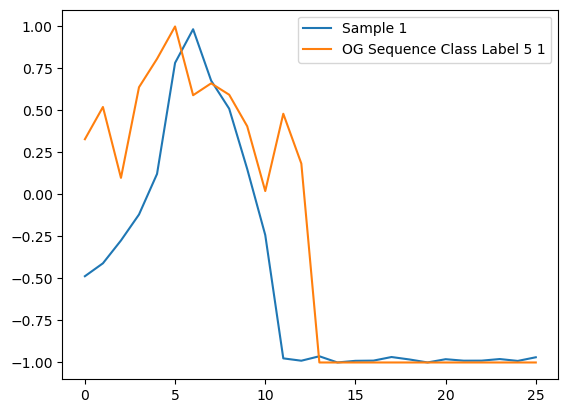

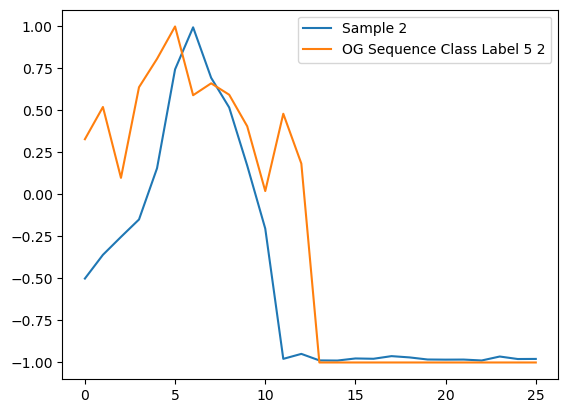

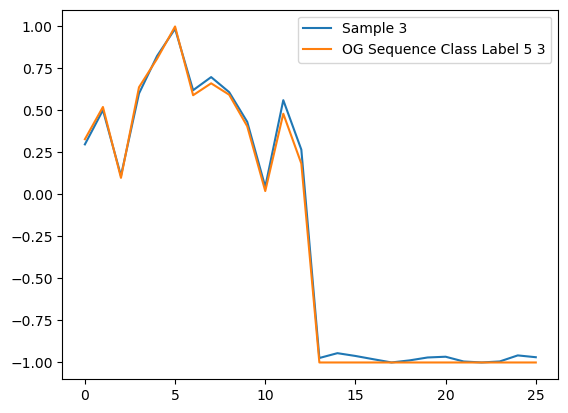

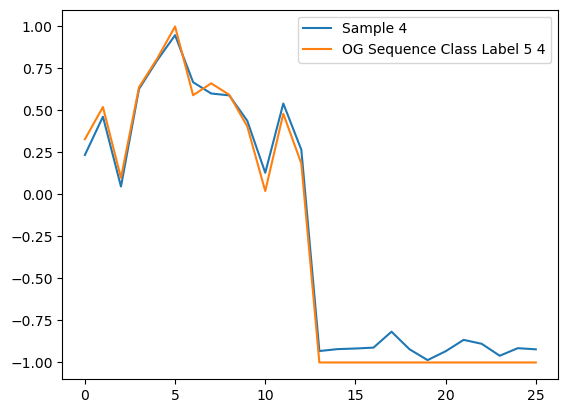

In [18]:
# NOTE: The following cell can take a long time for large DIFFUSION_STEPS

from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML

sample_batchsize = 4
class_ids = 5  # can be int or None

# Uncomment below to have determinstic sampling
g = None
# g = torch.Generator(device=device)
# g.manual_seed(0)

# Can try changing `num_inference_steps` here to check if we can diffuse a sample with fewer than DIFFUSION_TIMESTEPS steps
pipeline = ClassConditionedSequenceDDPMPipeline(model, noise_scheduler)
pipeline = pipeline.to(device)

pipe_output = pipeline(sample_batchsize, class_ids=class_ids, num_inference_steps=DIFFUSION_TIMESTEPS, generator=g, return_all=True)
samples = pipe_output.sequences

for idx, smp in enumerate(samples):
  plt.plot(smp.reshape(channels, timesteps)[0].cpu(), label=f'Sample {idx + 1}')

  if class_ids is not None:
    plt.plot(sequences[class_ids - 1].reshape(channels, timesteps)[0].cpu(), label=f'OG Sequence Class Label {class_ids} {idx + 1}')
  plt.legend()
  plt.show()

## Plotting the generation history

We can also observe the entire reverse diffusion process by plotting the history of a single channel over all the diffusion timesteps.

**Note**: For large number of diffusion timesteps, this step could take a long time.

In [ ]:
hist_sample_id = 1
channel_id = 0

################################################################################
history = pipe_output.history

assert hist_sample_id < len(history), "hist_sample_id cannot be greater than number of generated samples !"
assert channel_id < channels, f"channel_id {channel_id} cannot be greater than number of channels {channels}"

# create the figure and axes objects
fig, ax = plt.subplots()

def animate_sampling_history(i):
  h = history[i]

  ax.clear()
  ax.set_title(f"Sample Generated at Timestep {DIFFUSION_TIMESTEPS - i - 1}")
  ax.plot(h[hist_sample_id, channel_id].cpu(), label=f'Generated Sample')
  
  if class_ids is not None:
    ax.plot(sequences[class_ids - 1][channel_id].cpu(), label=f'Original Sequence (Class = {class_ids - 1})')
  ax.legend(loc="upper right")

# run the animation
anim = FuncAnimation(fig, animate_sampling_history, frames=list(range(DIFFUSION_TIMESTEPS)), interval=200, repeat=False)

rc('animation', html='jshtml')
HTML(anim.to_jshtml())

# Classifier Free Guidance

During training, at every batch there was a 10% probability to provide no class conditioning label to the model. 

We can now use that during inference to scale the weight of the conditioning label on the generated output.

From [Classifier-Free Diffusion Guidance](https://openreview.net/pdf?id=qw8AKxfYbI), we note that Equation 6 can be used during inference to scale the effect of the class label $c$ with some weight $ω$ at every reverse diffusion step when computing the model's estimate of the noise for that step.

\begin{equation}
    \tilde{ϵ_θ}(z_λ, c) = (1 + ω) ϵ_θ(z_λ, c) - ω ϵ_θ(z_λ, c=0)
\end{equation}

where $ϵ_θ(z_λ, c)$ is the model output **with the conditioning variable** and $ϵ_θ(z_λ, c=0)$ is the model output **without the conditioning variable**.

In [20]:
from diffusers import DiffusionPipeline
from typing import List, Optional, Tuple, Union

@dataclass
class SequenceDataOutput:
  sequences: List[torch.Tensor]
  history: List[torch.Tensor]


class ClassConditionedSequenceDDPMPipelineV2(DiffusionPipeline):

  def __init__(self, model: GPT, scheduler: DDPMScheduler):
    super().__init__()
    self.register_modules(model=model, scheduler=scheduler)

  @torch.no_grad()
  def __call__(self, 
        batch_size: int = 1,
        class_ids: Union[int, Optional[torch.Tensor]] = None,
        guidance_scale: Optional[float] = 0.0,  # This is the scale of the classifier free guidance; disabled by default.
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = DIFFUSION_TIMESTEPS,
        return_dict: bool = True,
        return_all: bool = False,  # new flag to return all the diffusion reverse process steps as a list
        explicit_noise: torch.Tensor = None,  # We can pass in an explicit loss value to ensure diffusion backward process is working as expected
        **kwargs,           
  ) -> SequenceDataOutput:
    self.scheduler: DDPMScheduler
    self.model: GPT

    # Get the sequence length from the notebook's globals as they were defined above when loading the dataset
    # Or use the user defined value if passed.
    # NOTE: Since we train on a single sample with exact seq_len and seq_dim, changing this will NOT work during inference.
    seq_len = kwargs.get('seq_len', timesteps)
    seq_dim = kwargs.get('channels', channels)

    # Sample noise as an init to the reverse process, if no noise was explicitly provided
    if explicit_noise is None:
      sequence_data = torch.randn(batch_size, seq_dim, seq_len, device=self.device, generator=generator)
    else:
      sequence_data = explicit_noise.to(device=device)

    # Set inference timesteps
    self.scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    # Check whether to mantain the history of all reverse diffusion process steps
    if return_all:
      history = [sequence_data.cpu()]
    else:
      history = None

    # Convert class_ids to tensor if not already
    if isinstance(class_ids, int):
      class_ids = torch.tensor(class_ids, device=self.device)

    if guidance_scale is not None and class_ids is None:
      raise ValueError("Cannot use `guidance_scale` (positive float) without `class_ids` !")
    
    if guidance_scale <= 0.0:
      guidance_scale = None  # If the scale is negative, we don't use the classifier free guidance

    for t in self.progress_bar(self.scheduler.timesteps):
        # 1. predict noise model_output
        model_output = self.model(sequence_data, t, cls=class_ids)

        # 2. implement classifier free guidance (CFG) if class_ids are provided
        # according to the paper [Classifier-Free Diffusion Guidance](https://openreview.net/pdf?id=qw8AKxfYbI)
        # equation 6 is implemented as below
        if guidance_scale is not None and class_ids is not None:
            # \tilde{epsilon(Z, c)} = (1 + w) * epsilon(Z, c) - w * epsilon(Z, c=0)
            model_output = (1. + guidance_scale) * model_output - guidance_scale * self.model(sequence_data, t, cls=None)

        # 3. compute previous image: x_t -> x_t-1  # prev_sample
        sequence_data = self.scheduler.step(model_output, t, sequence_data, generator=generator).prev_sample

        # Optional: Preserve history of intermediate step generation
        if history is not None:
          history.append(sequence_data.cpu().clone())
    
    # Clamp to allowed prediction range
    sequence_data = sequence_data.clamp(min=-1.0, max=1.0)
    
    if not return_dict:
        return (sequence_data,)

    return SequenceDataOutput(sequences=sequence_data, history=history)

# Sampling with classifier free guidance (CFG)

Below you can sample a batch of sequences, with some given `class_ids` that represent the Speaker ID and the corresponding strength of the classifier free guidance.

Some notes for `cfg_scale`:

* $0.0$ or less will disable Classifier Free Guidance
* `small values` will normally make the model closer to conditional generation (if `class_ids` is provided) without additional guidance. Note that because we train on such a small dataset, even conditional generation without guidance will be quite close to actual samples.
* `large values` will normally make the model adhere to the conditioning signal strongly, damaging results if there doesnt exist any good sample that satisfies the guidance signal. 
* `very large values` will degrade the generated sample to near noise.

100%|██████████| 50/50 [00:00<00:00, 126.90it/s]


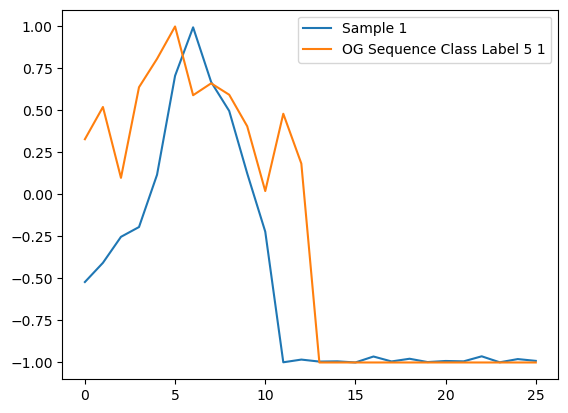

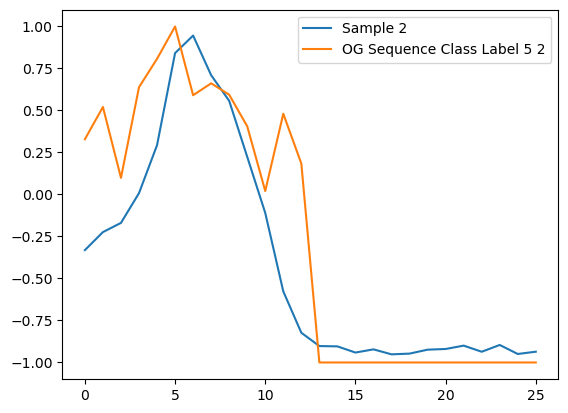

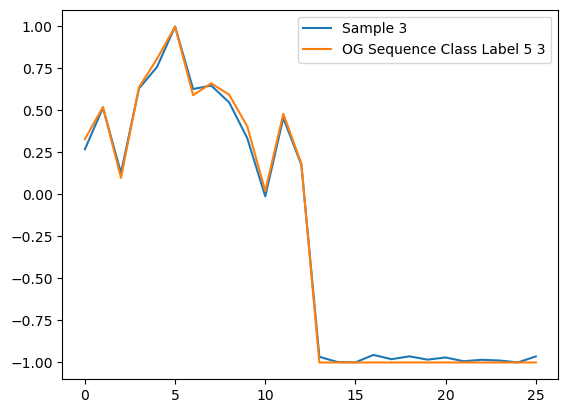

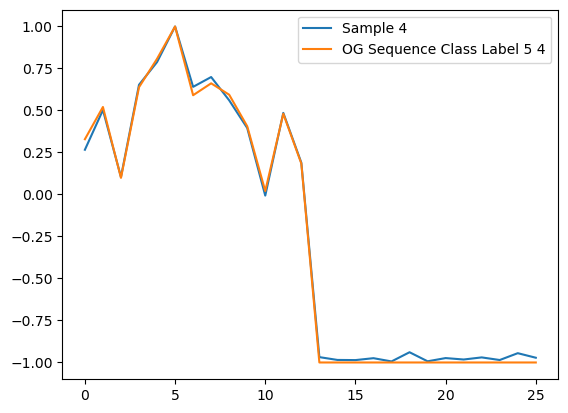

In [21]:
sample_batchsize = 4
class_ids = 5  # can be int or None
cfg_scale = 1  # Try values from 0.1 to 10.0 (or negative to disable CFG)

# We use a seed to compare generated samples given same batch size, class ids and different cfg scale.
g = None
g = torch.Generator(device=device)
g.manual_seed(0)

# Can try changing `num_inference_steps` here to check if we can diffuse a sample with fewer than DIFFUSION_TIMESTEPS steps
pipeline = ClassConditionedSequenceDDPMPipelineV2(model, noise_scheduler)
pipeline = pipeline.to(device)

pipe_output = pipeline(sample_batchsize, class_ids=class_ids, guidance_scale=cfg_scale, 
                       num_inference_steps=DIFFUSION_TIMESTEPS, generator=g, return_all=True)
samples = pipe_output.sequences

for idx, smp in enumerate(samples):
  plt.plot(smp.reshape(channels, timesteps)[0].cpu(), label=f'Sample {idx + 1}')

  if class_ids is not None:
    plt.plot(sequences[class_ids - 1].reshape(channels, timesteps)[0].cpu(), label=f'OG Sequence Class Label {class_ids} {idx + 1}')
  plt.legend()
  plt.show()

-----

Next, lets take a look at a single sample and the effect of different `cfg_scale` on the model.

We see that initially the model may not strictly be similar to the speakers base utterance, but as we increase `cfg_scale` it does start to resemble the sample more, until the scale is too strong and the sample quality degrades.

100%|██████████| 50/50 [00:00<00:00, 144.09it/s]


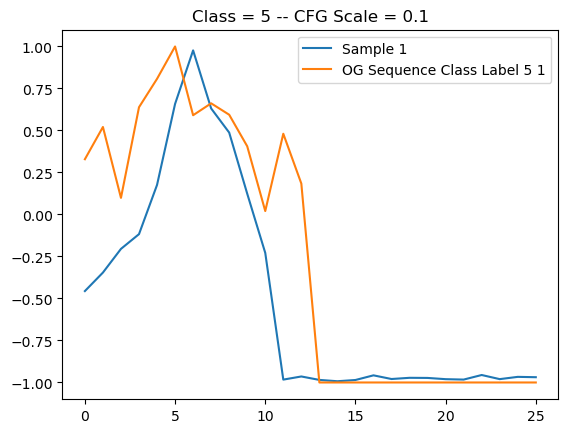

100%|██████████| 50/50 [00:00<00:00, 138.50it/s]


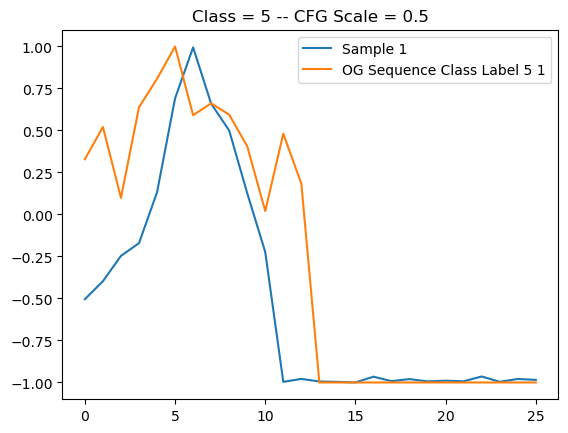

100%|██████████| 50/50 [00:00<00:00, 155.28it/s]


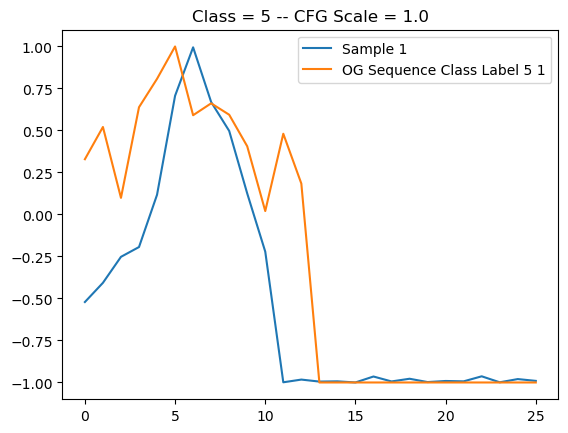

100%|██████████| 50/50 [00:00<00:00, 142.86it/s]


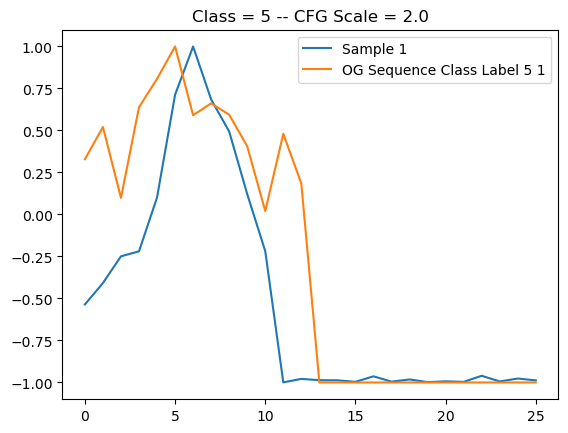

100%|██████████| 50/50 [00:00<00:00, 149.25it/s]


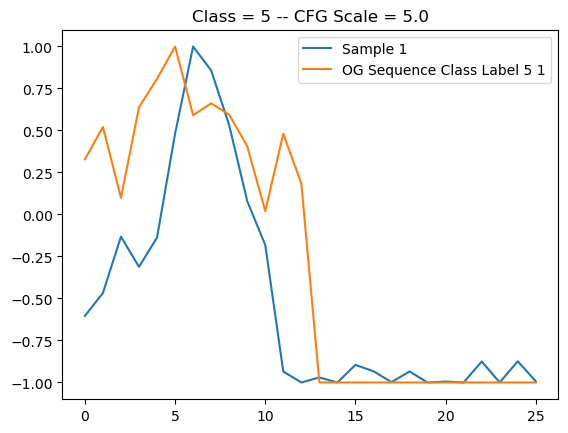

100%|██████████| 50/50 [00:00<00:00, 145.35it/s]


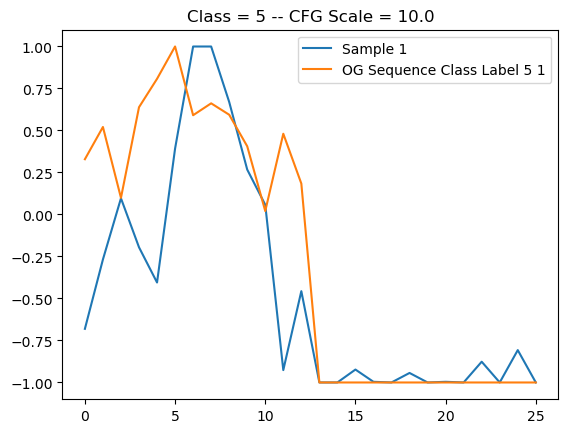

100%|██████████| 50/50 [00:00<00:00, 141.64it/s]


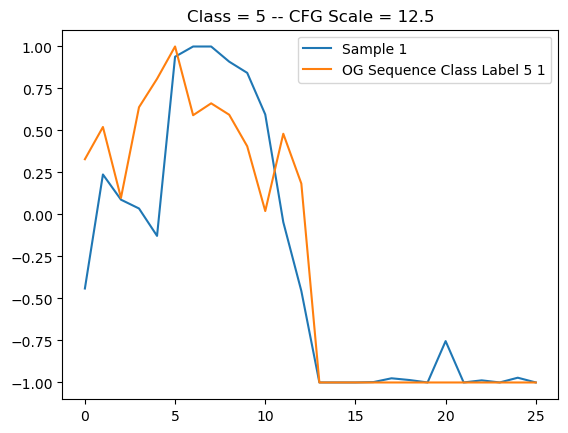

In [22]:
class_ids = 5  # can be int or None
cfg_scales = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 12.5]  # Try values from 0.1 to 10.0 (or negative to disable CFG)


for cfg_scale in cfg_scales:
  g = None
  g = torch.Generator(device=device)
  g.manual_seed(0)

  # Can try changing `num_inference_steps` here to check if we can diffuse a sample with fewer than DIFFUSION_TIMESTEPS steps
  pipeline = ClassConditionedSequenceDDPMPipelineV2(model, noise_scheduler)
  pipeline = pipeline.to(device)

  pipe_output = pipeline(1, class_ids=class_ids, guidance_scale=cfg_scale, 
                        num_inference_steps=DIFFUSION_TIMESTEPS, generator=g, return_all=True)
  samples = pipe_output.sequences

  for idx, smp in enumerate(samples):
    plt.title(f"Class = {class_ids} -- CFG Scale = {cfg_scale}")
    plt.plot(smp.reshape(channels, timesteps)[0].cpu(), label=f'Sample {idx + 1}')

    if class_ids is not None:
      plt.plot(sequences[class_ids - 1].reshape(channels, timesteps)[0].cpu(), label=f'OG Sequence Class Label {class_ids} {idx + 1}')
    plt.legend()
    plt.show()

# Conclusion

With this, we can now begin more advanced applications of diffusion models, such as latent diffusion, continious time schedules, stochastic sampling and so on.

Studying diffusion on a single sample allows us to understand the challenges of each technique, and how to successfully apply them.